In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib
from matplotlib import rcParams, rc
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd

rcParams["savefig.dpi"] = 150
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 10
rcParams['font.family'] = 'sans-serif'
%config InlineBackend.figure_format = "retina"

import sys
sys.path.append("/home/jdli/transpec")
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from tqdm import tqdm
import joblib 

from kvxp.apxp import MLP, simpMLP
from kvxp.data import GXP_5lb, GXP_AP_4lb
from kvxp.vis import *

from matplotlib.colors import LogNorm
import cmasher as cmr
cmap = cmr.dusk

from astropy.stats import bootstrap

boot_stat = lambda x: (np.percentile(x, 14), np.percentile(x, 50), np.percentile(x, 86))

def rmse(res):
    return np.sqrt(np.mean(res**2))

def mae(res):
    return np.median(np.abs(res))

In [199]:
def recover_scale_label(y_hat, e_y_hat,
                        scaler_name='../docs/models/scaler_labels_0208.gz', 
                        bias=2, scale_ext=10):
    scaler_labels = joblib.load(scaler_name)
    
    y   = scaler_labels.inverse_transform(y_hat/scale_ext-bias)
    e_y = (e_y_hat * scaler_labels.scale_)/scale_ext
    return y, e_y


def infer_4lbs_model(model, data_loader, transcale_method=recover_scale_label,
                     model2=None, model_pre=None,
                     model_type='attn', n_input=110, n_hi=116, n_cut=7534, n_output=4, n_dim=128, 
                     n_head=8, n_layer=8, cnn_idx=(0,110), coef_mask=None,
                     device=torch.device('cuda:0'), 
                     mask_band=None):
    
    out_lst1 = np.array([])
    out_lst2 = np.array([])
    out_lst3 = np.array([])
    id_lst = []

    with torch.no_grad():
        
        for data in tqdm(data_loader):
            
            if model_type == 'mlp':
                x = data['x']
                xp = x[:,:n_input]
                ap = x[:,n_input:]
                
                output  = model(xp)
                output_xpap = model_pre(model2(xp))
                output_ap = model_pre(ap)
                
            out_lst1   = np.append(out_lst1, output[:,:4].cpu().numpy())
            out_lst2  = np.append(out_lst2, output_xpap[:,:4].cpu().numpy())
            out_lst3  = np.append(out_lst3, output_ap[:,:4].cpu().numpy())
            id_batch =  list(np.int64(data['id']))
            
            for idl in id_batch:
                id_lst.append(idl)

    out_lst1  = np.array(out_lst1).reshape(-1,4)
    y,  _ = transcale_method(out_lst1, out_lst1)
    out_lst2 = np.array(out_lst2).reshape(-1,4)
    y2, _ =  transcale_method(out_lst2, out_lst2)
    out_lst3 = np.array(out_lst3).reshape(-1,4)
    y3, _ =  transcale_method(out_lst3, out_lst3)
    
    return {'labels':y, 'labels2':y2, 'labels3':y3, 'source_id':id_lst}


In [3]:
import os

spec_dir = "/data/jdli/sdss/dr17/spec_ap17_lbcut/"
ava_spec_names = os.listdir(spec_dir)
print(len(ava_spec_names))

268378


In [4]:
data_dir = "/data/jdli/gaia/"

gdf = pd.read_csv(data_dir+"ap17_gxp_train_81347.csv")

# tr_file = "ap17_wise_xp_66701_allstand1225.npy"
tr_file = "ap_xp_13286.npy"


device = torch.device('cuda:0')
# device = torch.device('cpu')
TOTAL_NUM = 6000
BATCH_SIZE = int(2**6)

gdata  = GXP_AP_4lb(
    data_dir+tr_file, total_num=TOTAL_NUM, 
    part_train=False,  device=device,
)
gdata_loader = DataLoader(gdata, batch_size=BATCH_SIZE)

# gdata[0]

x = gdata[0]['x'].cpu()

In [5]:
def remove_prefix(state_dict, unwanted_prefix = '_orig_mod.'):

    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
            
    return state_dict

num_fold  = 0
num_epoch = 500
preflix_name = "ap2_4l_{:d}_ep{:d}.pt"

model_xp_dir = data_dir    + "model/0220/" + f"xp2_4l_%d_ep%d.pt"%(num_fold,   num_epoch)
model_xp2ap_dir = data_dir + "model/0220/" + f"xp2ap_%d_ep%d.pt"%(num_fold, num_epoch)
model_pre_dir = data_dir+"model/0220/"+ "ap2_4l_%d_ep%d.pt"%(num_fold, 200)

print(model_xp_dir, model_xp2ap_dir, model_pre_dir)


/data/jdli/gaia/model/0220/xp2_4l_0_ep500.pt /data/jdli/gaia/model/0220/xp2ap_0_ep500.pt /data/jdli/gaia/model/0220/ap2_4l_0_ep200.pt


In [8]:
###### from transGaia.inference import *
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

n_xp = 110
n_ap = 7514
n_labels = 4
n_dim = 64
n_head = 4
n_layer = 2

pred_names   = ['teff', 'logg',  'moh', 'aom']
pred_names_preflix = [':XP', ':XP2AP2', ":AP"]

col_names = [p + pred_names_preflix[0] for p in pred_names] + [p + pred_names_preflix[1] for p in pred_names]+\
            [p + pred_names_preflix[2] for p in pred_names] + ['source_id']


for fold, (train_ids, valid_ids) in enumerate(kfold.split(gdata)):
    
    if fold==0:
        print(f'FOLD {fold}')
        print('--------------------------------')

        valid_subsampler = SubsetRandomSampler(valid_ids)
        train_subsampler = SubsetRandomSampler(train_ids)
        val_loader   = DataLoader(gdata, batch_size=BATCH_SIZE, sampler=valid_subsampler)
        tr_loader    = DataLoader(gdata, batch_size=BATCH_SIZE, sampler=train_subsampler)
        
        model_xp    = simpMLP(n_xp, n_labels, hidden_size=64 ).to(device)
        model_xp2ap = simpMLP(n_xp, n_ap).to(device)
        model_pre   = simpMLP(n_ap, n_labels).to(device)

        model_xp.load_state_dict(remove_prefix(torch.load(model_xp_dir)))
        model_xp2ap.load_state_dict(remove_prefix(torch.load(model_xp2ap_dir)))
        model_pre.load_state_dict(remove_prefix(torch.load(model_pre_dir)))

        labels_infer = infer_4lbs_model(
            model_xp, val_loader, model2=model_xp2ap, model_pre=model_pre,
            device=device, n_input=n_xp, 
            transcale_method=recover_scale_label, model_type='mlp',
        )

        rdf = pd.DataFrame(np.c_[
            labels_infer['labels'], labels_infer['labels2'], labels_infer['labels3'],
            labels_infer['source_id']], 
                           columns=col_names)

FOLD 0
--------------------------------


RuntimeError: Error(s) in loading state_dict for simpMLP:
	Unexpected key(s) in state_dict: "fc1.bias". 
	size mismatch for fc2.weight: copying a param with shape torch.Size([256, 64]) from checkpoint, the shape in current model is torch.Size([128, 64]).
	size mismatch for fc2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for fc3.weight: copying a param with shape torch.Size([64, 256]) from checkpoint, the shape in current model is torch.Size([64, 128]).

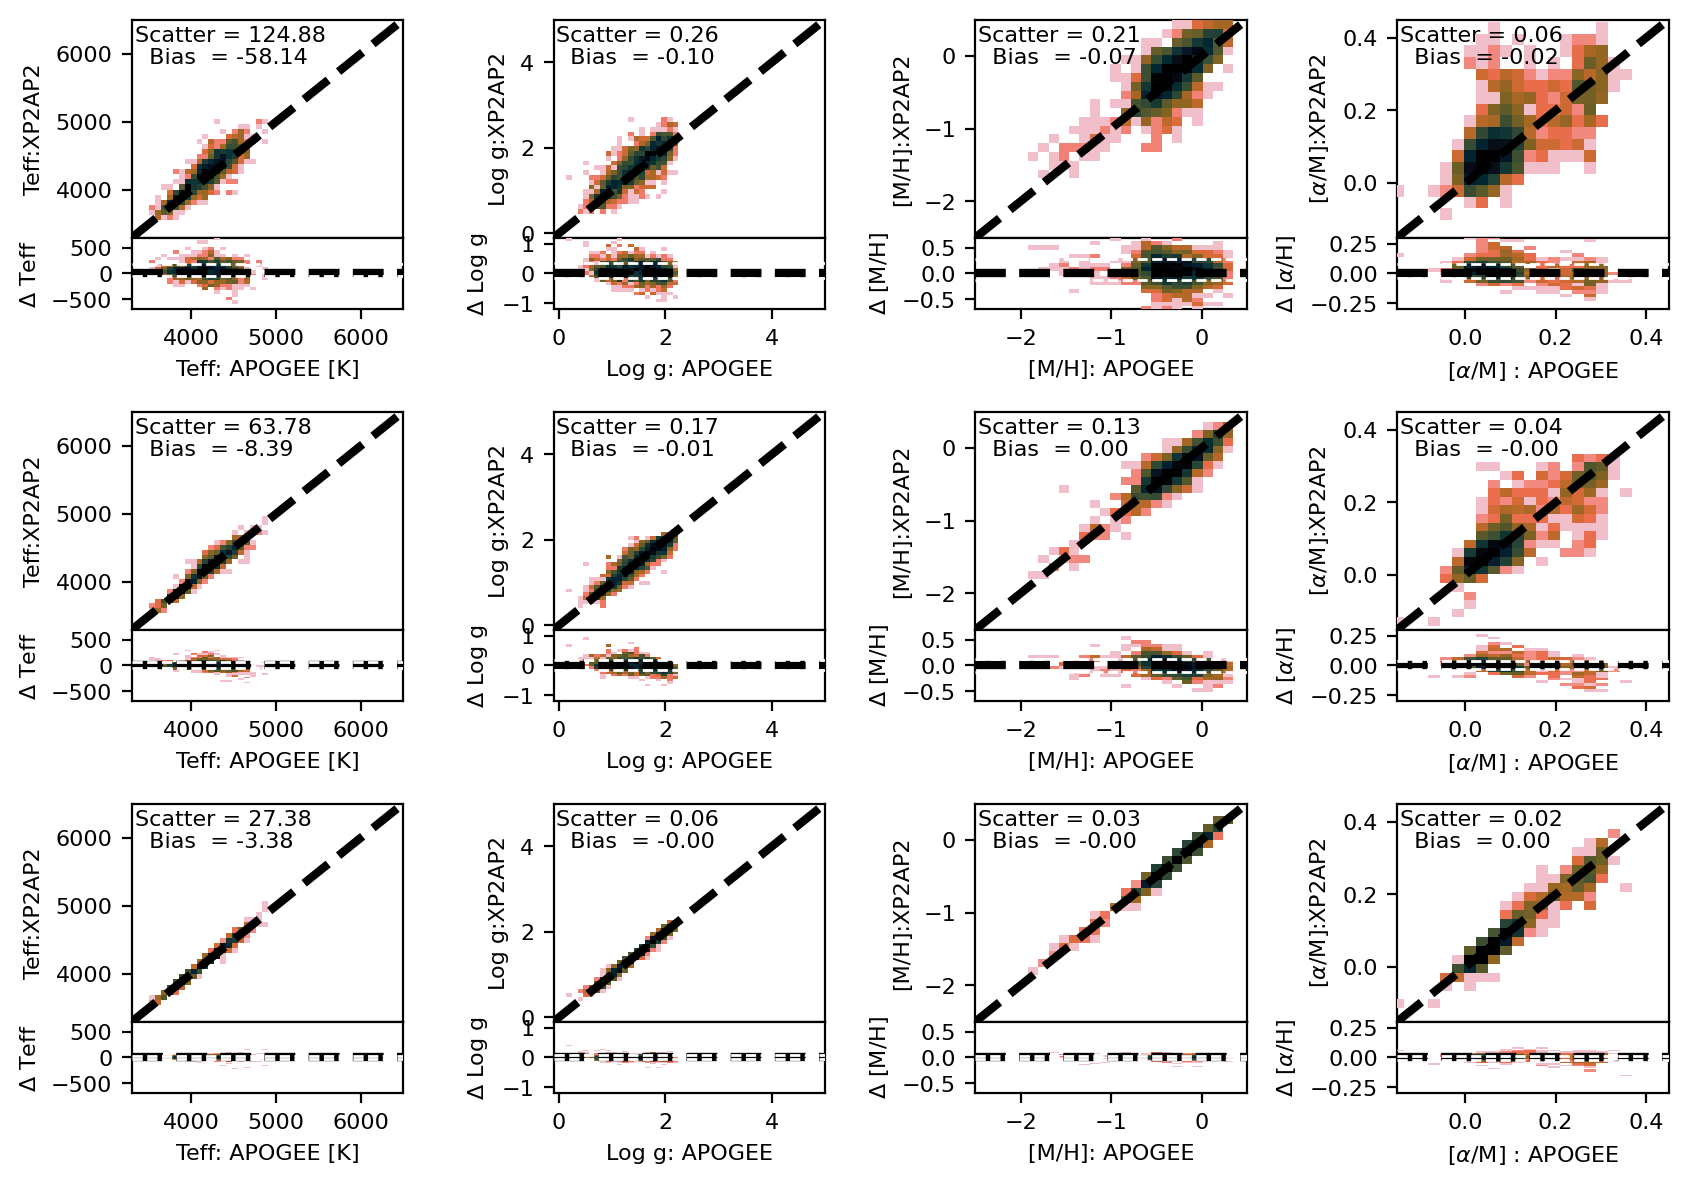

In [216]:
rcParams["font.size"] = 8
rdf_val = rdf.merge(gdf, left_on="source_id", right_on="GAIAEDR3_SOURCE_ID", suffixes=(None, '_y'))


N_model = 3
fig, axs = plt.subplots(N_model,4, figsize=(8.5, 2*N_model))

true_names = ['TEFF', 'LOGG', 'M_H', 'ALPHA_M']

xranges = [[3300, 6500], [-0.1, 5], [-2.5, 0.5], [-0.15, 0.45]]
yranges = [[-700, 700],  [-1.2, 1.2],   [-0.7, 0.7], [-0.3, 0.3]]
xlabels = ['Teff: APOGEE [K]', 'Log g: APOGEE', '[M/H]: APOGEE', r"[$\alpha$/M] : APOGEE"]
ylabels = ['Teff', 'Log g', '[M/H]', r'[$\alpha$/M]']
y2labels = [r'$\Delta$ Teff', r'$\Delta$ Log g', r'$\Delta$ [M/H]', r'$\Delta$ [$\alpha$/H]']

xticks  = [list(np.arange(4000, 7000, 500)), list(np.arange(1, 6, 1)), 
           list(np.arange(-2, 1, 0.5)),      list(np.arange(-0.2, 0.6, 0.2))]


for j in range(N_model): 
    for i in range(4):
        ynames = [p + pred_names_preflix[j] for p in pred_names]

        ax1, ax2 = draw_hist2d(
            axs[j,i], rdf_val[true_names[i]], rdf_val[ynames[i]],
            xrange=xranges[i], bins=20,
        )

        ylabel = [p + pred_names_preflix[1] for p in ylabels]

        ax1.set_ylabel(ylabel[i]);
        ax1.set_xticks([]);

        ax2.set_xlabel(xlabels[i]);
        ax2.set_ylabel(y2labels[i]);
        ax2.set_ylim(yranges[i]);
        
plt.tight_layout()